In [1]:
import sys
import time
import pickle
import numpy as np
import pandas as pd
from functools import partial, update_wrapper

from multiprocessing import Pool

from skimage import io
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras 
from keras import objectives
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

from scripts.image import load_image

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

In [3]:
# cross entropy that takes into account class weight
def weighted_crossentropy(y_true, y_pred, weight):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.dot(out, K.transpose(weight))

In [4]:
y_true = np.array([
    [1, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0]]
)
y_pred = np.array([
    [0.9, 0, 0, 0.3, 0, 0.2],
    [0.9, 0, 0, 0.3, 0, 0.2]]
)

In [5]:
# second example does better prediction and has lower loss
test_weight = np.array([[1., 1., 1., 1., 1., 1.]])
K.eval(weighted_crossentropy(K.variable(y_true), K.variable(y_pred), K.variable(test_weight)))

array([[ 2.07147384],
       [ 0.68517941]], dtype=float32)

In [6]:
# we don't care about last class, set small weith and the results are not that different any more
test_weight = np.array([[1., 1., 1., 1., 1., .1]])
K.eval(weighted_crossentropy(K.variable(y_true), K.variable(y_pred), K.variable(test_weight)))

array([[ 0.62297964],
       [ 0.4843502 ]], dtype=float32)

In [7]:
# create loss function with weights embedded
test_loss = wrapped_partial(weighted_crossentropy, weight = K.variable(test_weight))
K.eval(test_loss(K.variable(y_true), K.variable(y_pred)))

array([[ 0.62297964],
       [ 0.4843502 ]], dtype=float32)

In [8]:
img_rows, img_cols = 224, 224

In [9]:
images_preloaded = True
try:
    with open('data/images.pickle', 'rb') as handle:
        features, labels =  pickle.load(handle)
except:
    images_preloaded = False

In [10]:
# load images into memory
if(not images_preloaded):
    with open('data/tmdb_info.pickle', 'rb') as handle:
        tmdb_dict =  pickle.load(handle)
    with Pool(6) as p:
        rs = p.map_async(load_image, list(tmdb_dict.keys()))
        p.close()
        while (True):
            if (rs.ready()): break
            remaining = rs._number_left
            print("Waiting for", remaining, "tasks to complete...")
            time.sleep(10)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 22 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 14 tasks to complete...
Waiting for 10 tasks to complete...
Waiting for 6 tasks to complete...
Waiting for 1 tasks to complete...


In [11]:
# extract labes for the loaded images
if(not images_preloaded):
    labels = []
    features = []
    for r in rs.get():
        if(r[1] is not None):
            movie_genres = tmdb_dict[r[0]].__dict__['genres']
            if(movie_genres is None or len(movie_genres) == 0):
                continue
            labels.append([g['name'] for g in movie_genres])
            features.append(r[1])
    features = np.asarray(features)
    rs = None
    tmdb_dict = None

In [12]:
# create the labels vector
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
output_size = y.shape[1]
print('label matrix shape:', y.shape)

label matrix shape: (58825, 20)


In [13]:
class_freq = y.sum(axis = 0)
class_weight = class_freq.max()/class_freq
class_weight

array([  3.43354177,   6.49136102,   5.27593003,   1.43937357,
         5.53645295,   2.52923113,   1.        ,   6.09940188,
         9.90518039,  11.02161606,  15.28551035,   4.28043174,
         4.82645932,  10.5805336 ,   3.52046687,   8.64903069,
        18.21003401,   3.73083624,  17.24235105,  15.88649852])

In [14]:
# split into test / train data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state = 109, stratify = y)

In [15]:
print('Train label matrix shape:', y_train.shape)
print('Train predictor matrix shape:', X_train.shape)
print('Test label matrix shape:', y_test.shape)
print('Test predictor matrix shape:', X_test.shape)

Train label matrix shape: (44118, 20)
Train predictor matrix shape: (44118, 224, 224, 3)
Test label matrix shape: (14707, 20)
Test predictor matrix shape: (14707, 224, 224, 3)


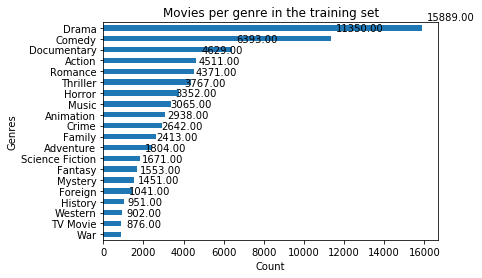

In [16]:
label_df = pd.DataFrame(y_train)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the training set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

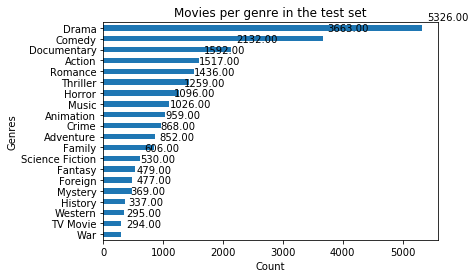

In [17]:
label_df = pd.DataFrame(y_test)
label_df.columns = mlb.classes_
label_number_df = pd.DataFrame({'cnt' : label_df.sum(axis = 0)})
ax = label_number_df.sort_values('cnt')['cnt'].plot(kind="barh", title = 'Movies per genre in the test set')
for p in ax.patches:
    ax.annotate(
        "%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')
plt.xlabel('Count')
plt.ylabel('Genres')

Model definition

In [41]:
earlyStopping = EarlyStopping(
    monitor='val_loss', patience = 5, min_delta = 0.01, verbose = 0, mode = 'min')

In [43]:
loss = wrapped_partial(weighted_crossentropy, weight = K.variable(np.array([class_weight])))

In [66]:
def get_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))
   
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation = 'sigmoid'))
    return model

In [67]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 24, 24, 128)       73856     
__________

In [68]:
model.compile(optimizer = 'nadam', loss = loss, metrics=['accuracy'])

In [70]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size = 128, 
    epochs = 50, 
    verbose = 1,
    validation_data = (X_test, y_test),
    callbacks = [earlyStopping]
)

Train on 44118 samples, validate on 14707 samples
Epoch 1/50
44118/44118 [==============================] - 225s - loss: 28.8971 - acc: 0.2426 - val_loss: 26.8566 - val_acc: 0.2400
Epoch 2/50
44118/44118 [==============================] - 222s - loss: 26.9977 - acc: 0.2648 - val_loss: 26.3956 - val_acc: 0.2621
Epoch 3/50
44118/44118 [==============================] - 220s - loss: 26.5583 - acc: 0.2706 - val_loss: 26.3653 - val_acc: 0.2533
Epoch 4/50
44118/44118 [==============================] - 224s - loss: 26.0064 - acc: 0.2803 - val_loss: 25.5904 - val_acc: 0.2911
Epoch 5/50
44118/44118 [==============================] - 222s - loss: 25.1119 - acc: 0.2877 - val_loss: 24.7844 - val_acc: 0.2943
Epoch 6/50
44118/44118 [==============================] - 221s - loss: 22.9693 - acc: 0.2954 - val_loss: 23.2425 - val_acc: 0.3140
Epoch 7/50
44118/44118 [==============================] - 223s - loss: 19.8985 - acc: 0.3139 - val_loss: 21.8382 - val_acc: 0.3142
Epoch 8/50
44118/44118 [=========

In [77]:
model.save('models/cnn_custom.h5')

In [72]:
model.compile(
    optimizer=SGD(lr = 0.0001, momentum=0.9), 
    loss=loss, 
    metrics=['accuracy'])

In [73]:
history = model.fit(
    X_train, 
    y_train, 
    class_weight = class_weight,
    batch_size = 128,
    epochs = 50, 
    verbose = 1,
    validation_data = (X_test, y_test),
    callbacks = [earlyStopping]
)

Train on 44118 samples, validate on 14707 samples
Epoch 1/50
44118/44118 [==============================] - 217s - loss: 9.1071 - acc: 0.4619 - val_loss: 21.5998 - val_acc: 0.3874
Epoch 2/50
44118/44118 [==============================] - 210s - loss: 8.9797 - acc: 0.4633 - val_loss: 21.4923 - val_acc: 0.3975
Epoch 3/50
44118/44118 [==============================] - 214s - loss: 8.8423 - acc: 0.4681 - val_loss: 21.3896 - val_acc: 0.3965
Epoch 4/50
44118/44118 [==============================] - 210s - loss: 8.8238 - acc: 0.4682 - val_loss: 21.5442 - val_acc: 0.3953
Epoch 5/50
44118/44118 [==============================] - 214s - loss: 8.8789 - acc: 0.4677 - val_loss: 21.4123 - val_acc: 0.3940
Epoch 6/50
44118/44118 [==============================] - 213s - loss: 8.7950 - acc: 0.4677 - val_loss: 21.8975 - val_acc: 0.3980
Epoch 7/50
44118/44118 [==============================] - 212s - loss: 8.6883 - acc: 0.4673 - val_loss: 21.8384 - val_acc: 0.3965
Epoch 8/50
44118/44118 [================

In [74]:
y_pred_proba = model.predict(X_test)
y_pred_test = np.zeros(y_pred_proba.shape)
y_pred_test[y_pred_proba > 0.5] = 1

In [75]:
print(classification_report(y_test, y_pred_test, target_names = mlb.classes_))

                 precision    recall  f1-score   support

         Action       0.76      0.21      0.34      1592
      Adventure       0.95      0.40      0.57       868
      Animation       0.88      0.53      0.66      1026
         Comedy       0.60      0.29      0.39      3663
          Crime       0.84      0.41      0.55       959
    Documentary       0.61      0.41      0.49      2132
          Drama       0.60      0.27      0.37      5326
         Family       0.88      0.53      0.66       852
        Fantasy       0.99      0.51      0.67       530
        Foreign       0.98      0.44      0.61       479
        History       1.00      0.51      0.67       369
         Horror       0.74      0.40      0.52      1259
          Music       0.84      0.45      0.58      1096
        Mystery       0.96      0.53      0.68       477
        Romance       0.85      0.24      0.37      1517
Science Fiction       0.97      0.46      0.63       606
       TV Movie       1.00    

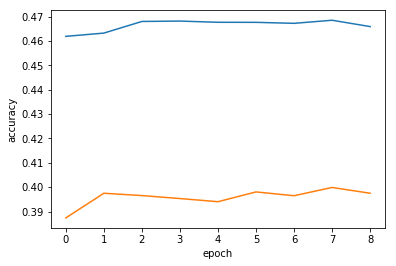

In [76]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")